# Load required libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Load the data, saved model and encoder

In [52]:
path_to_model = os.path.join('../artifacts', 'best_model' + '.pkl')
model = pickle.load(open(path_to_model, 'rb'))


path_to_encoder = os.path.join('../artifacts/')
ohe = pickle.load(open(path_to_encoder + 'encoder.pkl', 'rb'))



path_to_data = os.path.join('../data/')
X_train = pd.read_parquet( path_to_data + 'X_train.parquet')
X_test = pd.read_parquet( path_to_data + 'X_test.parquet')
y_train = pd.read_parquet( path_to_data + 'y_train.parquet')
y_test = pd.read_parquet( path_to_data + 'y_test.parquet')

# features which needs to be one hot encoded
columns_one_hot = ['GENDER', 'RACE', 'ETHNIC', 'MARSTAT', 'EMPLOY', 'VET' ,	'LIVARAG',	'PRIMINC',
                   'DIVISION',	'SERVICES' ,  'PSOURCE' , 	'SUB1' , 	'FREQ1', 
                   'PSYPROB' ,	'FREQ_ATND_SELF_HELP']

In [53]:
# resetting index to avoid errors while concatenating
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

One hot encoding the features

In [54]:
X_categorical = pd.DataFrame( ohe.transform(X_train[columns_one_hot]),  columns= ohe.get_feature_names_out())
X_numerical = X_train.drop(columns_one_hot,axis=1)
X_train_transformed = pd.concat([X_numerical, X_categorical],axis=1)

# Calculating SHAP values

In [55]:
import shap
shap.initjs()

In [56]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed.head(100000))


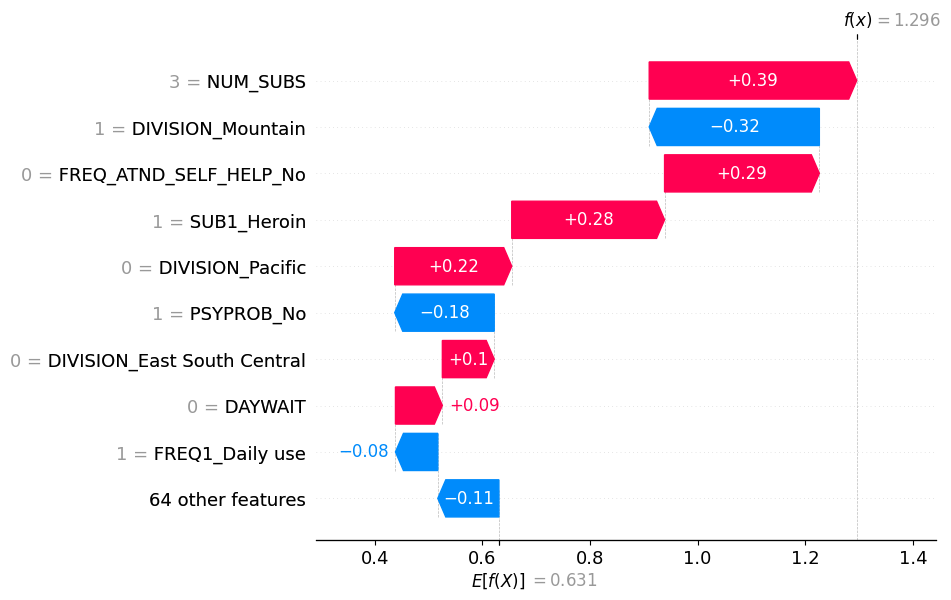

In [62]:
# Get shap values and the efffects of features for a particular client
client_id = 3
shap.plots.waterfall(shap_values[client_id])


In [67]:
#creating dataframe of all the shap values
shap_df = pd.DataFrame(shap_values.values, columns=X_train_transformed.columns)

In [68]:
# summing shap values over original catewgorical variables
shap_df_temp = pd.DataFrame()
for feature in X_train.columns:
    shap_df_temp[feature] = shap_df.filter(regex="^{}".format(feature), axis=1).sum(axis=1)



In [69]:
 # assigning new shap values
shap_values.values = shap_df_temp.values
shap_values.data = X_train.values
shap_values.feature_names = list(X_train.columns)


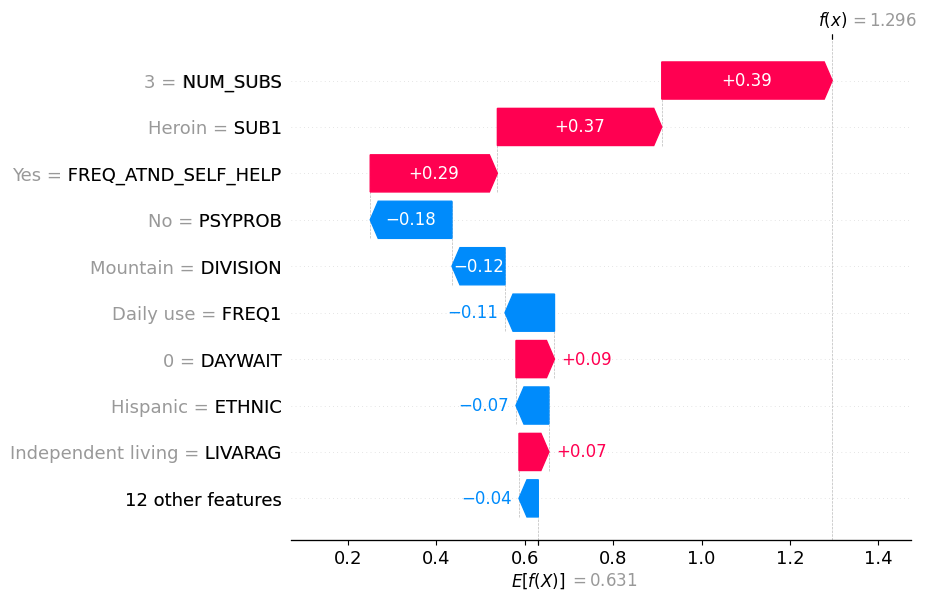

In [70]:
shap.plots.waterfall(shap_values[client_id])

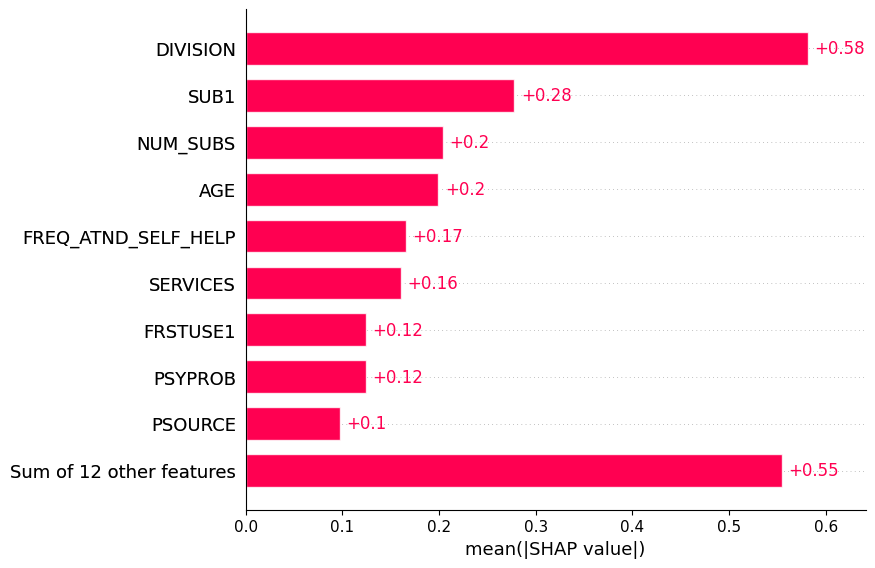

In [71]:
#Mean SHAP
shap.plots.bar(shap_values)